In [1]:
import os
import sys
import numpy as np
from tqdm.notebook import tqdm
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import mpl_toolkits.axes_grid1.inset_locator as mpl_il
import seaborn as sns
import pandas as pdf
# from randpy.randpy import ran1
# from functions import *
import pickle
from datasets.stas import save_sta
import math
# rng = np.random.default_rng()
sns.set_context("notebook")
home = '/usr/users/vystrcilova/retinal_circuit_modeling/'


ModuleNotFoundError: No module named 'datasets'

In [4]:


def save_sta(response_file, image_file,  save_dir, save_file, time_bins):
    if not isinstance(image_file, str):
        images = image_file
    else:
        images = np.load(image_file)
    with open(response_file, 'rb') as f:
        responses = pickle.load(f)
    responses = responses['test_responses']
    responses = np.moveaxis(responses, 1, 2)
    # responses = responses[:, :, :11]

#     images /=255
#     images = (1 - -1) * (images - 0) / (1 - 0) + -1
    height, width = images.shape[1:]
    all_stas = np.zeros((responses.shape[0], ) + (time_bins, height, width))
    for cell in range(responses.shape[0]):
        sta = calculate_initial_stas(responses, images, cell_index=cell,
                               time_bins=time_bins, height=height, width=width)
        print('cell', cell)
        all_stas[cell] = sta
        show_sta(sta, cell=cell)

    np.save(f'{home}/{save_dir}/{save_file}', all_stas)



In [2]:
def calculate_initial_stas(responses, images, cell_index, time_bins, height, width):
    sta = np.zeros((time_bins, height, width))
    spike_count = 0
    cell_responses = responses[cell_index]

    for trial in tqdm(range(cell_responses.shape[-1])):
        trial_responses = cell_responses[:, trial]
        for i, response in enumerate(trial_responses):
            if i > time_bins and response > 0:
                sta += response*images[i-time_bins:i]
                spike_count += response
    sta = sta/spike_count
    # sta /= np.linalg.norm(sta)
    return sta

In [3]:
from matplotlib import gridspec


def show_sta(sta, cell):
    fig = plt.figure(figsize=(20, 24))
    gs = gridspec.GridSpec(10, 5, width_ratios=[1, 1, 1, 1 ,1],
         wspace=0.05, hspace=0.05, top=0.95, bottom=0.05, left=0.17, right=0.845)
    for i in range(sta.shape[0]):
        x = math.floor(i/5)
        y = i % 5
        ax = plt.subplot(gs[x,y])
        ax.set_axis_off()
        ax.imshow(sta[i], cmap='gray', vmin=-1, vmax=1)
    ax = plt.subplot(gs[0, 2])
    ax.set_title(f'Cell {cell}')
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    # plt.tight_layout()
    plt.savefig('/Users/m_vys/Documents/doktorat/CRC1456/retinal_circuit_modeling/datasets/visualization_plots/marmoset_data/retina1/cell_0/sta_fixation_movie_22.png')
    plt.show()

In [5]:
time_bins = 50
images = np.load(f'{home}/data/marmoset_data/repeating_stimuli_wn/all_images.npy')

  0%|          | 0/11 [00:00<?, ?it/s]

cell 0


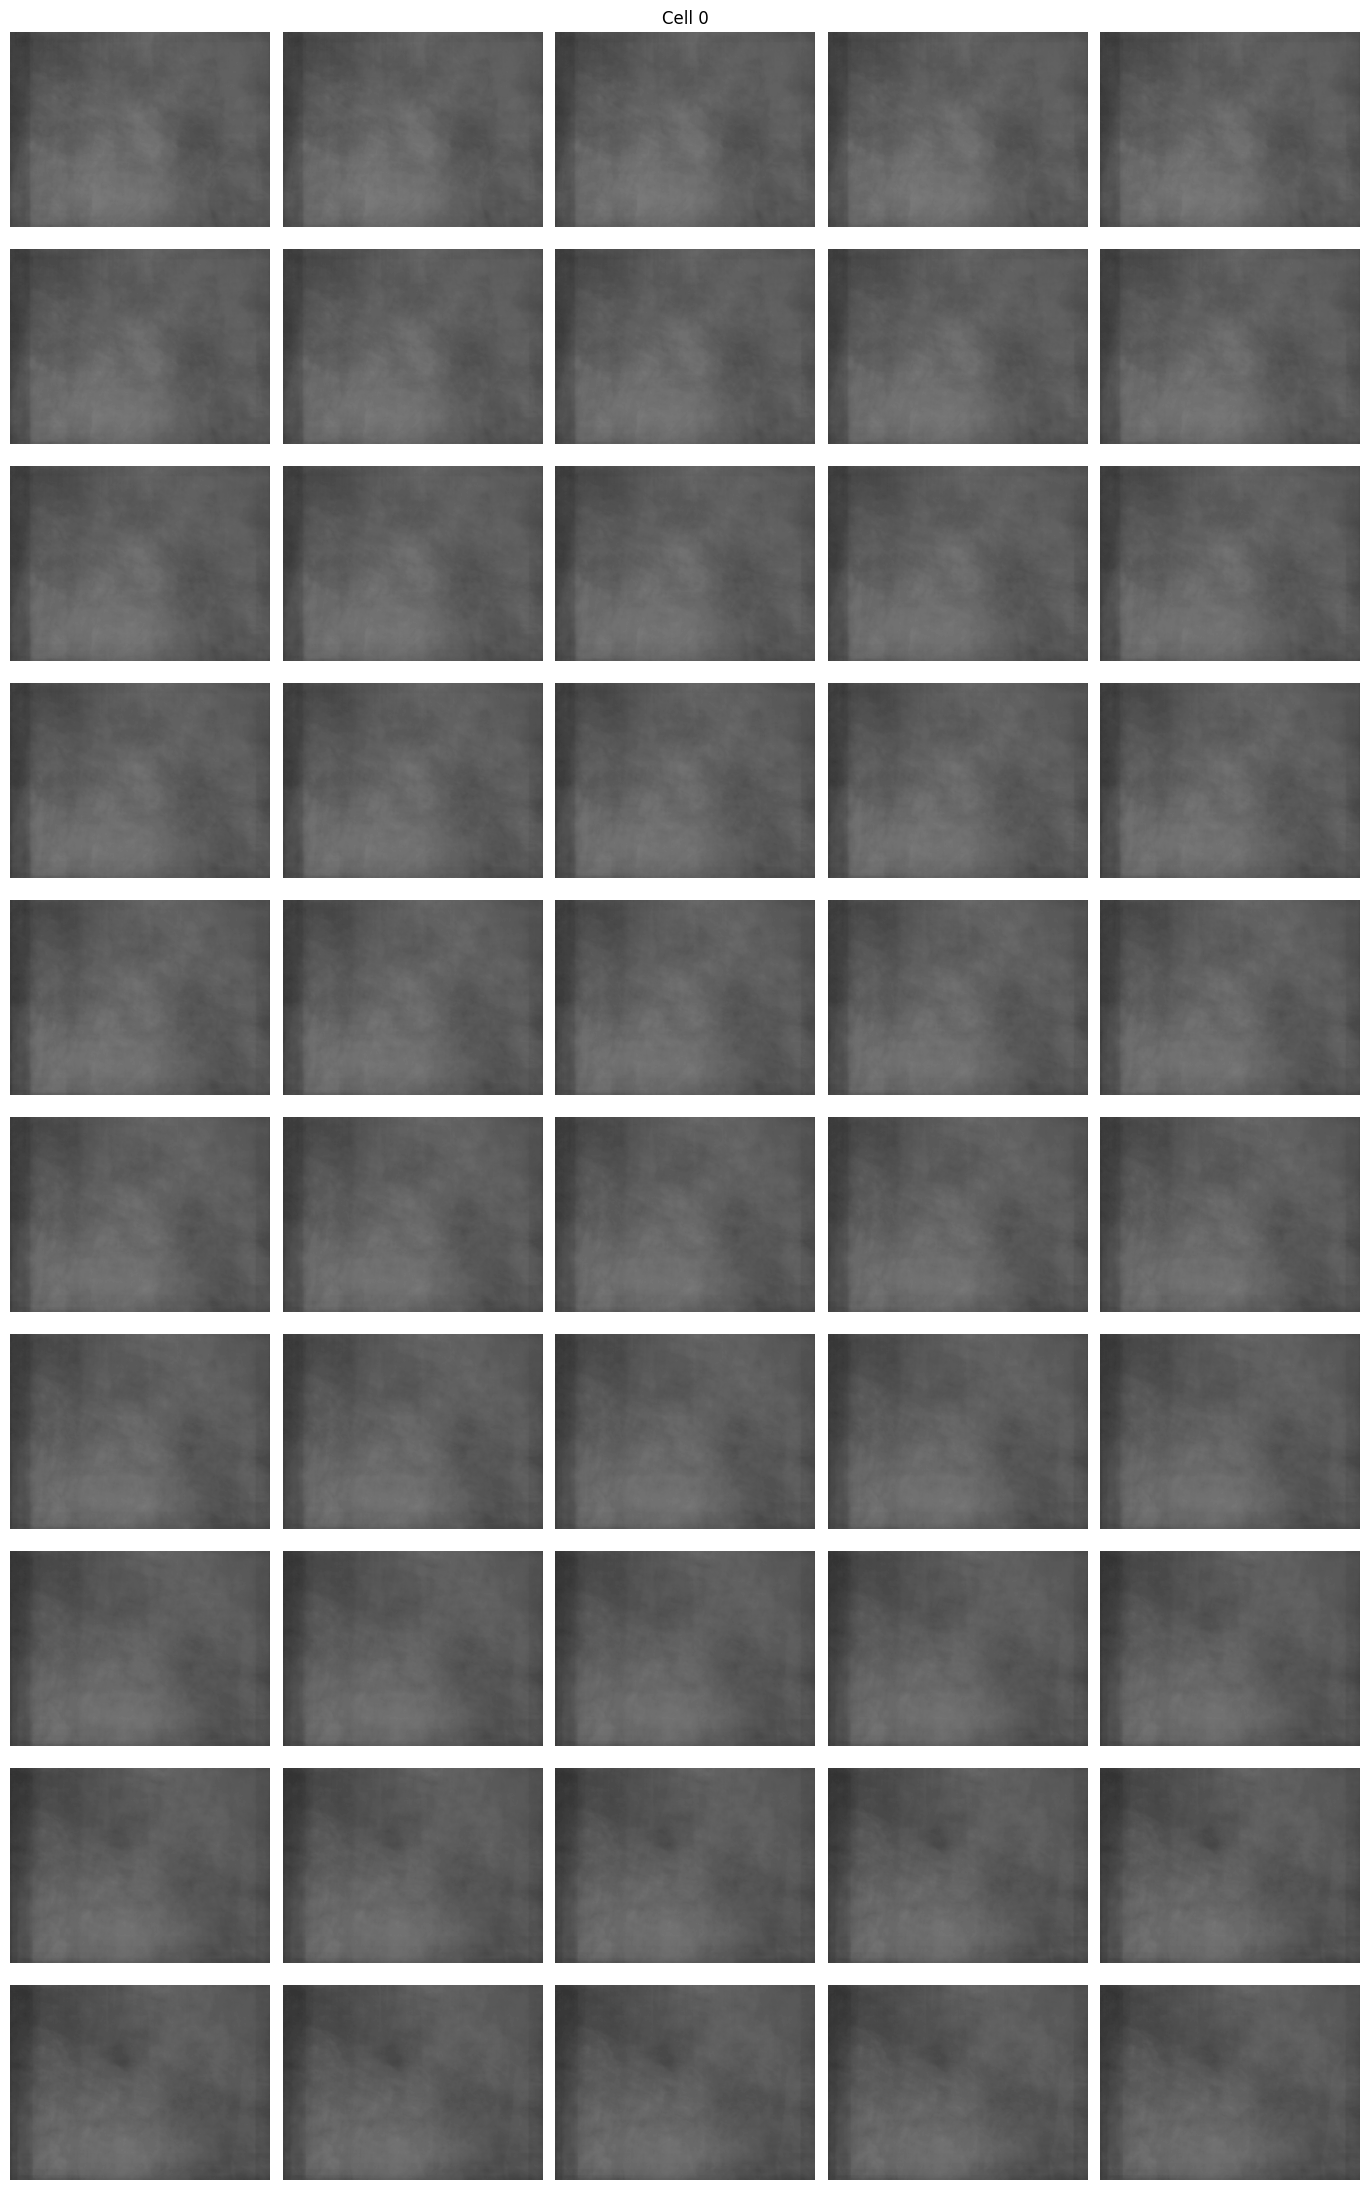

  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
save_sta(f'{home}/data/marmoset_data/responses/cell_responses_01_fixation_movie.pkl',
             image_file=images,
             save_dir=f'{home}/data/marmoset_data/', save_file=f'cell_dat_01_NC_stas_{time_bins}_seed_2022.npy', time_bins=time_bins)

In [11]:
def get_random_stimuli(seed, time_bins, height, width):
    print(seed, time_bins, height, width)
    random_number, next_seed = ran1(seed, time_bins * height * width)
    stimulus = np.heaviside(np.array(random_number) - 0.5, 1).astype(int) * 2 - 1
    stimulus = np.reshape(stimulus, (height, width, time_bins))
    return stimulus, next_seed


def load_stimulus_array(kind, time_bins, height, width, trial_id=None, seed=None):
    if kind == "frozen":
        if os.path.exists("../data/marmoset_data/repeating_stimuli_wn/all_images.npy"):
            stimuli = np.load("../data/marmoset_data/repeating_stimuli_wn/all_images.npy")
            next_seed = None
        else:
            if seed is None:
                frozen_seed = -20000
            else:
                frozen_seed = seed
            stimuli, next_seed = get_random_stimuli(frozen_seed, time_bins, height, width)
            np.save("../data/marmoset_data/repeating_stimuli_wn/all_images.npy", stimuli)
    elif kind == "running":
        if trial_id is None:
            raise("For running noise, a valid trial id is required!")

        filename = f"../non_repeating_stimuli_wn/trial{str(trial_id).zfill(3)}.npy"
        if os.path.exists(filename):
            stimuli = np.load(filename)
            next_seed = None
        else:
            if seed is None:
                running_seed = -10000
            else:
                running_seed = seed
            stimuli, next_seed = get_random_stimuli(running_seed, time_bins, height, width)
            np.save(f"../data/marmoset_data/non_repeating_stimuli_wn/trial{str(trial_id).zfill(3)}.npy")
    else:
        raise ValueError(f"Invalid kind of stimulus requested: {kind}\nUse either 'frozen' or 'running'.")
        
    return stimuli, next_seed


def scale(x, out_range=(-1, 1)):
    domain = np.min(x), np.max(x)
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2


def get_mis_pos(array):
    """Returns the position of the most important stixel in the array.
    """
    temporal_variances = np.var(array, axis=0)
    pix_pos = np.unravel_index(np.argmax(temporal_variances), (array.shape[1], array.shape[2]))
    time_pos = np.argmin(array[:, pix_pos[0], pix_pos[1]])
    return (time_pos, pix_pos[0], pix_pos[1])


def get_sta(response_array, cell, noise_kind, height, width, kernel_size, vmin=-1, vmax=1):
    time_bins = response_array.shape[2]
    
    summed_stimuli = np.zeros((height, width, kernel_size))
    next_seed = None
    spike_count = 0
    for t in tqdm(range(response_array[cell].shape[1]-1),
                         desc="Trials", leave=False):
        print(f't: {t}')
        stimuli, next_seed = load_stimulus_array(kind=noise_kind, time_bins=time_bins, 
                                                 height=height, width=width, trial_id=t,
                                                 seed=next_seed)
        print(stimuli.shape)
        for b in range(response_array[cell, :, t].shape[0]):
            bin_count = response_array[cell, b, t]
            print(f'b:, {b}, bin_count: {bin_count}, trial: {t}' )
            if b > kernel_size and bin_count > 0:
                print(summed_stimuli.shape, stimuli.shape)
#                 summed_stimuli += bin_count * np.transpose(stimuli[b - kernel_size:b, ...], (1, 2, 0))
                summed_stimuli += bin_count*stimuli[:, :, b-kernel_size:b]
                spike_count += bin_count
    print(spike_count)
    print(summed_stimuli.shape)

    sta = summed_stimuli / spike_count
   # sta /= np.linalg.norm(sta)
    
    return np.transpose(sta, (2, 0, 1))

In [12]:
load_stimulus_array(seed=-10000, kind='frozen', time_bins=time_bins, height=height, width=width)

(array([[[-1,  1, -1, ...,  1, -1, -1],
         [-1, -1, -1, ...,  1, -1, -1],
         [ 1,  1, -1, ...,  1,  1,  1],
         ...,
         [-1,  1,  1, ...,  1,  1,  1],
         [ 1,  1, -1, ..., -1, -1, -1],
         [-1,  1,  1, ...,  1,  1, -1]],
 
        [[ 1, -1,  1, ...,  1,  1, -1],
         [-1,  1, -1, ...,  1,  1,  1],
         [-1,  1, -1, ...,  1,  1, -1],
         ...,
         [ 1,  1, -1, ..., -1, -1,  1],
         [ 1,  1,  1, ...,  1, -1, -1],
         [ 1,  1,  1, ...,  1,  1, -1]],
 
        [[-1,  1, -1, ...,  1, -1,  1],
         [ 1, -1, -1, ...,  1, -1,  1],
         [-1, -1, -1, ...,  1, -1,  1],
         ...,
         [ 1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ...,  1,  1,  1],
         [-1,  1,  1, ..., -1,  1,  1]],
 
        ...,
 
        [[ 1, -1, -1, ...,  1, -1, -1],
         [ 1, -1,  1, ..., -1, -1,  1],
         [-1, -1,  1, ...,  1, -1,  1],
         ...,
         [-1,  1,  1, ...,  1,  1, -1],
         [ 1,  1,  1, ...,  1, -1,  1],


In [ ]:
frozen[0].shape[1]-1

In [6]:
datasets_path = "../data/marmoset_data/responses/"
stimuli_path = "../data/marmoset_data/non_repeating_stimuli_wn/"

In [7]:
dataset = "cell_responses_01_initial_white_noise.pkl"
with open(os.path.join(datasets_path, f"{dataset}"), 'rb') as f:
    experiment = pickle.load(f)

frozen, running = experiment["test_responses"], experiment["train_responses"]
frozen = np.ascontiguousarray(np.transpose(frozen, (0, 2, 1)))
running = np.ascontiguousarray(np.transpose(running, (0, 2, 1)))
print(experiment['seed'])

{'frozen': -10000, 'running': -1001}


In [8]:
print(running.shape)
print(frozen.shape)

(370, 12750, 11)
(370, 2550, 11)


In [9]:
time_bins, height, width = frozen.shape[-2], 600, 800
n_trials = frozen.shape[-1]
n_cells = frozen.shape[0]
kernel_size = 25

In [10]:
cell = 0

In [ ]:
repeating_stimuli = np.load('../data/marmoset_data/repeating_stimuli_wn/all_images.npy')

In [ ]:
print(repeating_stimuli.shape)
# plt.imshow(repeating_stimuli[:, :, 150], cmap='gray')
# plt.show()

In [ ]:
cell = 16
kernel_size=25
next_seed = None
spike_triggered_average = get_sta(response_array=frozen, cell=cell, noise_kind="frozen",
                                  height=height, width=width, kernel_size=kernel_size)

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

t: 0
(600, 800, 2550)
b:, 0, bin_count: 0, trial: 0
b:, 1, bin_count: 0, trial: 0
b:, 2, bin_count: 0, trial: 0
b:, 3, bin_count: 0, trial: 0
b:, 4, bin_count: 0, trial: 0
b:, 5, bin_count: 0, trial: 0
b:, 6, bin_count: 0, trial: 0
b:, 7, bin_count: 0, trial: 0
b:, 8, bin_count: 0, trial: 0
b:, 9, bin_count: 0, trial: 0
b:, 10, bin_count: 0, trial: 0
b:, 11, bin_count: 0, trial: 0
b:, 12, bin_count: 0, trial: 0
b:, 13, bin_count: 0, trial: 0
b:, 14, bin_count: 0, trial: 0
b:, 15, bin_count: 0, trial: 0
b:, 16, bin_count: 0, trial: 0
b:, 17, bin_count: 0, trial: 0
b:, 18, bin_count: 0, trial: 0
b:, 19, bin_count: 0, trial: 0
b:, 20, bin_count: 0, trial: 0
b:, 21, bin_count: 0, trial: 0
b:, 22, bin_count: 0, trial: 0
b:, 23, bin_count: 0, trial: 0
b:, 24, bin_count: 0, trial: 0
b:, 25, bin_count: 0, trial: 0
b:, 26, bin_count: 0, trial: 0
b:, 27, bin_count: 0, trial: 0
b:, 28, bin_count: 0, trial: 0
b:, 29, bin_count: 0, trial: 0
b:, 30, bin_count: 0, trial: 0
b:, 31, bin_count: 0, trial

In [ ]:
spike_triggered_average.shape

In [ ]:
sta_min, sta_max = spike_triggered_average.min(), spike_triggered_average.max()

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=kernel_size//4, constrained_layout=True, figsize=(kernel_size//2, 6), sharex=True, sharey=True)
for a, ax in enumerate(axes.flatten()):
    ax.imshow(spike_triggered_average[a, :, :], cmap='gray')
    ax.set(xticklabels=[], yticklabels=[])
    ax.tick_params(left=False, bottom=False)
plt.show()

# Most important stixel

In [ ]:
t_, y_, x_ = get_mis_pos(spike_triggered_average)

In [ ]:
print(f"{t_}, {y_}, {x_}")

In [ ]:
spike_triggered_average.shape

In [ ]:
plt.close()
fig, ax = plt.subplots(constrained_layout=True)
ax.imshow(spike_triggered_average[t_, :, :], vmin=sta_min, vmax=sta_max, cmap='gray')
c = plt.Circle((x_, y_), 15, fc=(0.0, 0.0, 0.8, 0.2))
ax.add_patch(c)
plt.show()

In [ ]:
plt.close()
fig, ax = plt.subplots()
ax.plot(spike_triggered_average[:, y_, x_])
ax.set_xlabel("Time {x33.33ms)")
ax.set_ylabel("Filter amplitude (arb. units)")
ax.set_title(f"Filter kernel for cell {cell}")
plt.show()

In [ ]:
stas = []
for c in tqdm(range(n_cells), desc="Cells"):
    stas.append(get_sta(response_array=running, cell=c, noise_kind="running",
                        height=height, width=width, kernel_size=kernel_size))

In [ ]:
stas_array = np.array(stas)

In [ ]:
stas_array.shape

In [ ]:
np.save(f"{dataset}_stas_{kernel_size}.npy", stas_array)